<a href="https://colab.research.google.com/github/jorgelorenz/personal_portfolio/blob/main/Final_maze_generator_cvxpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Maze generator with CVXPY
>Author: Jorge Lorenzo García

>LinkedIn: https://www.linkedin.com/in/jorge-lorenzo-garc%C3%ADa-05943421b/







## Introduction
Maze generation algorithms ([Wikipedia](https://en.wikipedia.org/wiki/Maze-solving_algorithm#:~:text=The%20maze%2Drouting%20algorithm%20is,for%20any%20grid%2Dbased%20maze.)) are a widely studied topic related to computer science and graph theory.

Here we provide an algorithm based on the one made by Benjamin Godlove in
https://brg8.medium.com/generating-a-maze-with-linear-constraint-programming-58a7bd0723f5

The main idea is to create the constraints that allows us to have a solvable maze and then use cvxpy library to get a solution which is a maze.



## The optimization problem

$$
\begin{array}{ll} \mbox{maximize} & \sum_{i=0}^{N-1}\sum_{j=0}^{N-1} x_{ij} \\
\mbox{subject to} & x_{ij}, y_{ij} \in \{ 0,1 \} \; \forall i,j=0,1,..N-1,  \\
& x_{10} = 0 , \; x_{N-2N-1}=0\\
& x_{i-1j} + x_{i+1j} + x_{ij-1} + x_{ij+1} <= 3 \; \forall i,j=1,..N-2 \\
& x_{i-1j} + x_{i+1j} + x_{ij-1} + x_{ij+1} + x_{ij} <= 4 \; \forall i,j=1,..N-2 \\
& y_{10} = 1 , \; y_{11} = 1, \; y_{N-2N-1} = 1, \; y_{N-2N-2} = 1 \\
& y_{i-1j} + y_{i+1j} + y_{ij-1} + y_{ij+1} - 2 * y_{ij} >= 0 \; \forall i,j=1,..N-2 \\
& y_{i-1j} + y_{i+1j} + y_{ij-1} + y_{ij+1} + 2 * y_{ij} <= 4 \; \forall i,j=1,..N-2 \\
& x_{ij} + y_{ij} <= 1 \; \forall i,j=0,..N-1 \\
& \sum_{i=0}^{N-1} x_{0i} = N \; \forall i,j=0,..N-1 \\
& \sum_{i=0}^{N-1} x_{N-1i} = N \; \forall i,j=0,..N-1 \\
& \sum_{i=0}^{N-1} x_{i0} = N - 1 \; \forall i,j=0,..N-1 \\
& \sum_{i=0}^{N-1} x_{iN-1} = N - 1 \; \forall i,j=0,..N-1 \\
& \sum_{j=0}^{N-1} x_{ij} <= \lceil{N/2}\rceil \forall i=1,..N-2\\
& x_{i-1j} + x_{i+1j} + x_{ij-1} + x_{ij+1} <= 4 \; \forall i,j=1,..N-2 \\
\end{array}
$$ \\
We define the walls variables: $$x_{ij}$$ 1 if there are wall in block
(i,j) 0 otherwise. \\
We maximize the amount of walls with some conditions: \\
·We declare the entry and the exit. \\
·For each block there should be at least one free adyacent block. \\
·A free block there should have at least one free adyacent block. \\
·We also declare constraints for the outside walls.
We define the solution path y:
·The entry and the exit should be in the solution path. \\
·A block in the solution path should be a free block not a wall. \\
·A block in the solution path should have exactly two adyacents blocks in the solution path (except from entry and exit). \\

And some equations to do de maze more complex.

## The program

In [ ]:
import cvxpy as cp

import math

WALL = "#"
FREE_SPACE = " "
TOLERANCE = 0.05
PATH = "*"

def show_maze(x,y, N):
  for i in range(N):
    row = []
    for j in range(N):
        if x[(i,j)].value >= 1 - TOLERANCE:
          print(WALL, end="")
        else:
          if y[(i,j)].value >= 1 - TOLERANCE :
            print(PATH, end="")
          else:
            print(FREE_SPACE, end="")
    print()



def maze_generation(N=10, show=True):
  #Initialize x
  x = {}
  y = {}

  for i in range(N):
    for j in range(N):
      x[(i,j)] = cp.Variable(1, boolean=True)
      y[(i,j)] = cp.Variable(1, boolean=True)
  #Objective function

  objective = sum(sum( x[(i,j)] for i in range(N) ) for j in range(N))

  #Constraints
  constraints = []

  constraints += [ x[(1,0)] == 0 ]
  constraints += [ x[(N-2, N-1)] == 0 ]
  constraints += [ y[(1,0)] == 1 ]
  constraints += [ y[(1,1)] == 1 ]
  constraints += [ y[(N-2,N-1)] == 1 ]
  constraints += [ y[(N-2,N-2)] == 1 ]

  for i in range(1,N-1):
    constraints += [sum( x[(i,j)] for j in range(N)) <= math.ceil(N/2.0)]
    for j in range(1,N-1):
      constraints += [x[(i-1,j)] + x[(i+1,j)] + x[(i,j-1)] + x[(i,j+1)] <=3]
      constraints += [x[(i-1,j)] + x[(i+1,j)] + x[(i,j-1)] + x[(i,j+1)] + x[(i,j)] <=4]
      constraints += [y[(i-1,j)] + y[(i+1,j)] + y[(i,j-1)] + y[(i,j+1)] + 2*y[(i,j)] <=4]
      constraints += [y[(i-1,j)] + y[(i+1,j)] + y[(i,j-1)] + y[(i,j+1)] - 2*y[(i,j)] >=0]
      constraints += [x[(i,j-1)] + x[(i-1,j-1)] + x[(i-1,j)] + x[(i,j)] >= 1]

  for i in range(N):
    constraints += [x[(0,i)] == 1]
    constraints += [x[(N-1,i)] == 1]
    if i != 1 :
      constraints += [x[(i,0)] == 1]
    if i != N-2 :
      constraints += [x[(i,N-1)] == 1]
    for j in range(N):
      constraints += [x[(i,j)] + y[(i,j)] <= 1]


  #Solving
  prob = cp.Problem(cp.Maximize(objective), constraints)
  prob.solve(solver=cp.GLPK_MI)

  #Showing
  if show :
    show_maze(x,y, N)

maze_generation()

##########
*****#####
## #*#   #
##  *# # #
## #*#   #
### ***# #
# # ##***#
# # #  #*#
### ##  **
##########


## Efficiency

As we see clearly, the number of constraints is O(n^2) and the number of variables in some of such constraints is O(n) so the program won't scale efficiently because Simplex won't. Let compute it.

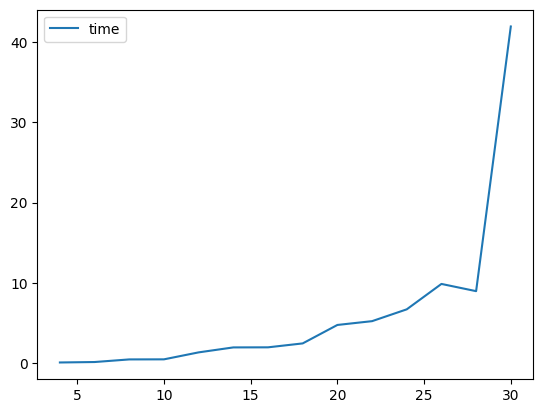

In [ ]:
import time as time
from numpy import array
import pandas as pd

def compute_time():
  beginning = 4
  end = 32
  times = []
  for i in range(beginning,end,2):
    start = time.time()
    maze_generation(i, show=False)
    finish = time.time()
    times.append( (i, array([finish - start])) )

  y, x= [item[1][0] for item in times], [item[0] for item in times]

  df = pd.DataFrame(index=range(beginning, end, 2) ,data={'time': y})
  df.plot()

compute_time()


We see the algorithm has exponential order.

## Conclusions
Python CVXPY library is faster for this algorithm (at least until N=14) than glp library in Ruby that Benjamin used in his code. \\
Also, we can compare the Ruby code and Python which is easier and more readble in my opinion.